# Integrating `MLflow` to SMS Spam Detection

#### Importing Necessary Libraries

Also, suppressing warnings to keep the output clean.

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_recall_curve, auc
from prettytable import PrettyTable
from mlflow.tracking import MlflowClient
import random
import mlflow
import mlflow.sklearn

import warnings
warnings.filterwarnings('ignore')

#### Loading and Cleaning Data

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
validation_df = pd.read_csv('validation.csv')

# There are some empty sms filed, hence removing them
train_df.dropna(inplace=True)
validation_df.dropna(inplace=True)
test_df.dropna(inplace=True)

label_mapping = {'ham': 0, 'spam': 1}
train_df['label'] = train_df['label'].map(label_mapping)
validation_df['label'] = validation_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

#### Combining Training and Validation Data

In [7]:
combined_df = pd.concat([train_df, validation_df])

## How MLflow Works

MLflow is an open-source platform to manage the ML lifecycle, including experimentation, reproducibility, and deployment.

### Key Components

1. **Tracking**: Log parameters, metrics, and artifacts.
2. **Projects**: Standardize and execute code.
3. **Models**: Package and deploy models.
4. **Registry**: Manage model lifecycle.

### Basic Workflow

1. **Set Up Tracking**:
    - Initialize MLflow and set the tracking URI.
    - Start a new run using `mlflow.start_run()`.

2. **Log Parameters and Metrics**:
    - Use `mlflow.log_param()` to log hyperparameters.
    - Use `mlflow.log_metric()` to log performance metrics.

3. **Log Models**:
    - Use `mlflow.sklearn.log_model()` to log a trained model.

4. **End Run**:
    - End the run using `mlflow.end_run()`.

5. **View Results**:
    - Use the MLflow UI to visualize and compare runs.

#### Setting up `mlflow`

- First run `mlflow ui` in the terminal.

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("SMS Spam Detection Experiment")

<Experiment: artifact_location='mlflow-artifacts:/586477112453009050', creation_time=1741103584959, experiment_id='586477112453009050', last_update_time=1741103584959, lifecycle_stage='active', name='SMS Spam Detection Experiment', tags={}>

#### Writing `utility functions`

In [ ]:
def hyperparameter_tune(model, param_grid, X_train, y_train):
    """
    Performs grid search cross-validation to find optimal hyperparameters.
    Args:
        model: Classifier model
        param_grid: Dictionary with parameters names (string) as keys and lists of parameter settings to try
        X_train: Training data features
        y_train: Training data labels
    Returns:
        Best fitted model based on cross-validation score
    """
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    
    mlflow.log_params(grid_search.best_params_)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "model")
    
    mlflow.log_metric("best roc_auc cv score", grid_search.best_score_)
    mlflow.log_param("model_name", model.__class__.__name__)
    
    return grid_search.best_estimator_

def evaluate_model(model, X, y, set=""):
    """
    Evaluates model performance using AUC-PR and logs the metric to MLflow.
    """
    predictions = model.predict(X)
    precision, recall, _ = precision_recall_curve(y, predictions)
    auc_pr = auc(recall, precision)
    
    # Log the AUC-PR to MLflow
    mlflow.log_metric(f"{set}_auc_pr", auc_pr)

    return auc_pr


## Building the benchmark models

#### Random Forest Classifier

In [ ]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

model = RandomForestClassifier(random_state=42)

with mlflow.start_run(run_name="RandomForest_Classifier"):
    best_model_rf = hyperparameter_tune(model, param_grid, combined_df['text'], combined_df['label'])
    evaluate_model(best_model_rf, combined_df['text'], combined_df['label'], set="train")
    evaluate_model(best_model_rf, test_df['text'], test_df['label'], set="test")
    mlflow.register_model("runs:/{}/random_forest_model".format(mlflow.active_run().info.run_id), "random_forest_model")

mlflow.end_run()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best cross-validation score:  0.9931581779974866


2025/03/04 21:44:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'random_forest_model' already exists. Creating a new version of this model...
2025/03/04 21:44:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_model, version 2


🏃 View run RandomForest_Classifier at: http://127.0.0.1:5000/#/experiments/586477112453009050/runs/1c41edd36c0644abb32eb02a64567777
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/586477112453009050


Created version '2' of model 'random_forest_model'.


#### Decision Tree Classifier

In [43]:
param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2, 4]
}

model = DecisionTreeClassifier(random_state=42)

with mlflow.start_run(run_name="DecisionTree_Classifier"):
    best_model_dt = hyperparameter_tune(model, param_grid, combined_df['text'], combined_df['label'])
    evaluate_model(best_model_dt, combined_df['text'], combined_df['label'], set="train")
    evaluate_model(best_model_dt, test_df['text'], test_df['label'], set="test")
    mlflow.register_model("runs:/{}/decision_tree_model".format(mlflow.active_run().info.run_id), "decision_tree_model")

mlflow.end_run()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Best cross-validation score:  0.9306030955862689


2025/03/04 21:44:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'decision_tree_model'.
2025/03/04 21:44:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: decision_tree_model, version 1


🏃 View run DecisionTree_Classifier at: http://127.0.0.1:5000/#/experiments/586477112453009050/runs/198d8e601629496eb38c4a8ee9c9de72
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/586477112453009050


Created version '1' of model 'decision_tree_model'.


#### Logistic Regression Classifier

In [44]:
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
}

model = LogisticRegression(random_state=42)

with mlflow.start_run(run_name="LogisticRegression_Classifier"):
    best_model_lr = hyperparameter_tune(model, param_grid, combined_df['text'], combined_df['label'])
    evaluate_model(best_model_lr, combined_df['text'], combined_df['label'], set="train")
    evaluate_model(best_model_lr, test_df['text'], test_df['label'], set="test")
    mlflow.register_model("runs:/{}/logistic_regression_model".format(mlflow.active_run().info.run_id), "logistic_regression_model")

mlflow.end_run()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best cross-validation score:  0.9916943723315997


2025/03/04 21:46:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'logistic_regression_model'.
2025/03/04 21:46:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_regression_model, version 1


🏃 View run LogisticRegression_Classifier at: http://127.0.0.1:5000/#/experiments/586477112453009050/runs/5c1ec1e924324839ba8e8b282aefca03
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/586477112453009050


Created version '1' of model 'logistic_regression_model'.


#### Support Vector Classifier

In [45]:
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [1, 0.1, 0.01, 0.001],
    'clf__kernel': ['linear', 'rbf']
}

model = SVC(random_state=42)

with mlflow.start_run(run_name="SVC_Classifier"):
    best_model_svc = hyperparameter_tune(model, param_grid, combined_df['text'], combined_df['label'])
    evaluate_model(best_model_svc, combined_df['text'], combined_df['label'], set="train")
    evaluate_model(best_model_svc, test_df['text'], test_df['label'], set="test")
    mlflow.register_model("runs:/{}/svc_model".format(mlflow.active_run().info.run_id), "svc_model")

mlflow.end_run()

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
Best cross-validation score:  0.9932960722078912


2025/03/04 21:49:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'svc_model'.
2025/03/04 21:49:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: svc_model, version 1


🏃 View run SVC_Classifier at: http://127.0.0.1:5000/#/experiments/586477112453009050/runs/5e27c5424d254c26becf5b26f5b84e6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/586477112453009050


Created version '1' of model 'svc_model'.


#### Multinomial Naive Bayes

In [46]:
param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

model = MultinomialNB()

with mlflow.start_run(run_name="MultinomialNB_Classifier"):
    best_model_nb = hyperparameter_tune(model, param_grid, combined_df['text'], combined_df['label'])
    evaluate_model(best_model_nb, combined_df['text'], combined_df['label'], set="train")
    evaluate_model(best_model_nb, test_df['text'], test_df['label'], set="test")
    mlflow.register_model("runs:/{}/multinomial_nb_model".format(mlflow.active_run().info.run_id), "multinomial_nb_model")

mlflow.end_run()


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'clf__alpha': 0.1}
Best cross-validation score:  0.9916664578666244


2025/03/04 21:50:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'multinomial_nb_model'.
2025/03/04 21:50:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: multinomial_nb_model, version 1


🏃 View run MultinomialNB_Classifier at: http://127.0.0.1:5000/#/experiments/586477112453009050/runs/4d8c95c153c84eaa83429405a1bece40
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/586477112453009050


Created version '1' of model 'multinomial_nb_model'.


## Evaluating the benchmark models

#### Writing `utility` functions

In [ ]:
def plot_precision_recall_curve(y_true, y_pred):
    """
    Plots the Precision-Recall curve.
    
    Args:
    y_true: True labels
    y_pred: Predicted labels
    """
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    auc_pr = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AUC-PR Curve (AUC={auc_pr:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return auc_pr

def load_and_evaluate_model(run_id, model_name):
    """
    Loads a model from a specific run and evaluates it on the test set.
    
    Args:
    run_id (str): The run ID of the model to load.
    model_name (str): The name of the model to load.
    
    Returns:
    None
    """
    model_uri = f"runs:/{run_id}/model"
    loaded_model = mlflow.sklearn.load_model(model_uri)

    X_test = test_df['text']
    y_test = test_df['label']
    predictions = loaded_model.predict(X_test)
    print(f"Precision recall curve for {model_name}")
    auc_pr = plot_precision_recall_curve(y_test, predictions)

    return auc_pr

In [22]:
run_model_mapping = [
    {"run_id": "1c41edd36c0644abb32eb02a64567777", "model_name": "RandomForest"},
    {"run_id": "198d8e601629496eb38c4a8ee9c9de72", "model_name": "DecisionTree"},
    {"run_id": "5c1ec1e924324839ba8e8b282aefca03", "model_name": "LogisticRegression"},
    {"run_id": "5e27c5424d254c26becf5b26f5b84e6a", "model_name": "SVC"},
    {"run_id": "4d8c95c153c84eaa83429405a1bece40", "model_name": "MultinomialNB"}
]

#### Plotting the AUCPRs

Precision recall curve for RandomForest


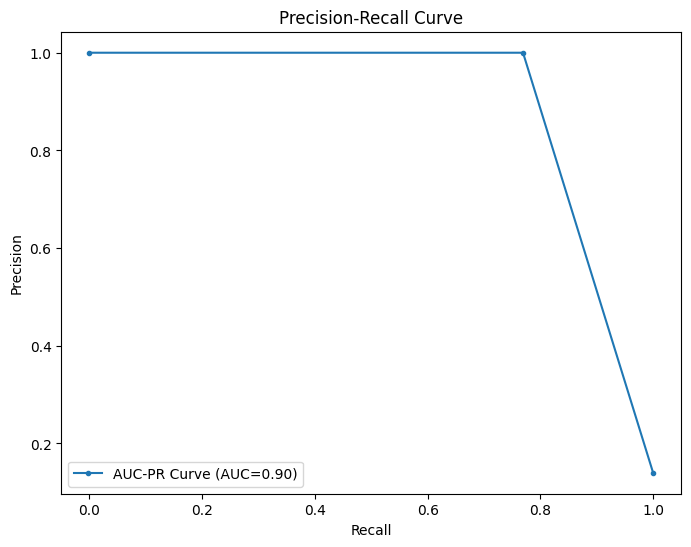

Precision recall curve for DecisionTree


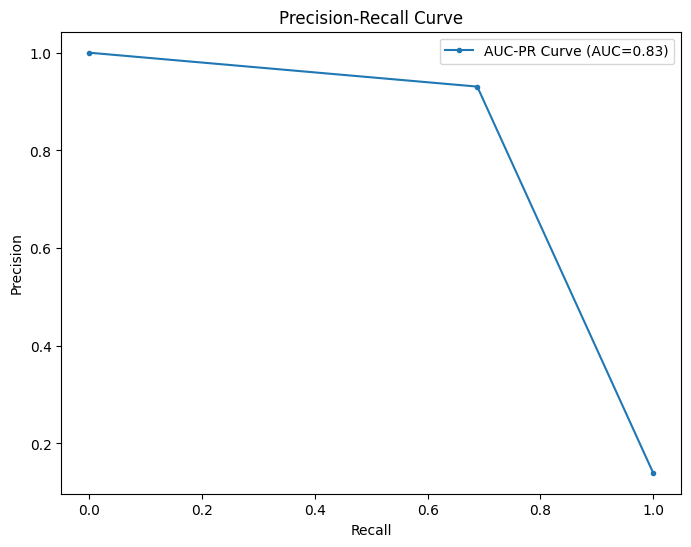

Precision recall curve for LogisticRegression


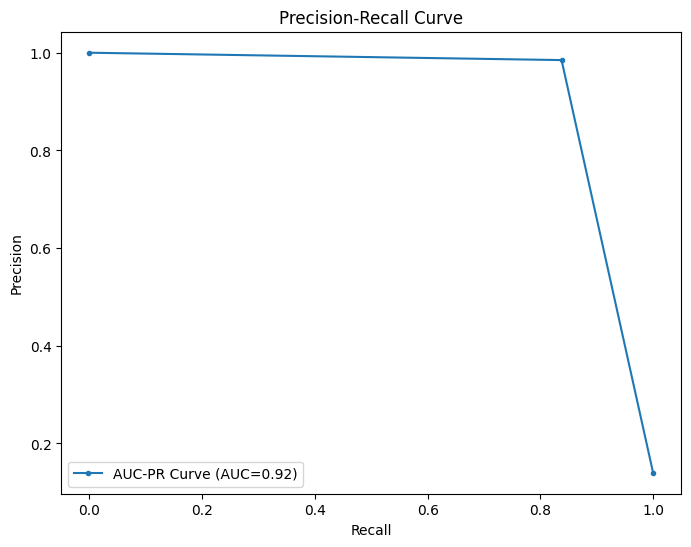

Precision recall curve for SVC


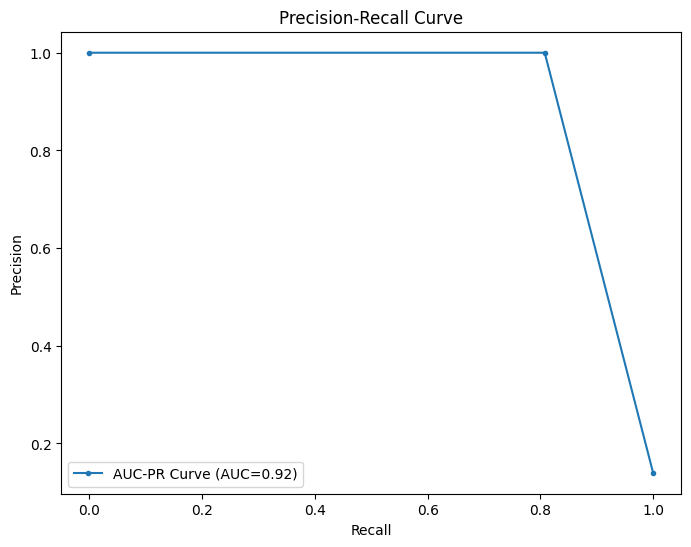

Precision recall curve for MultinomialNB


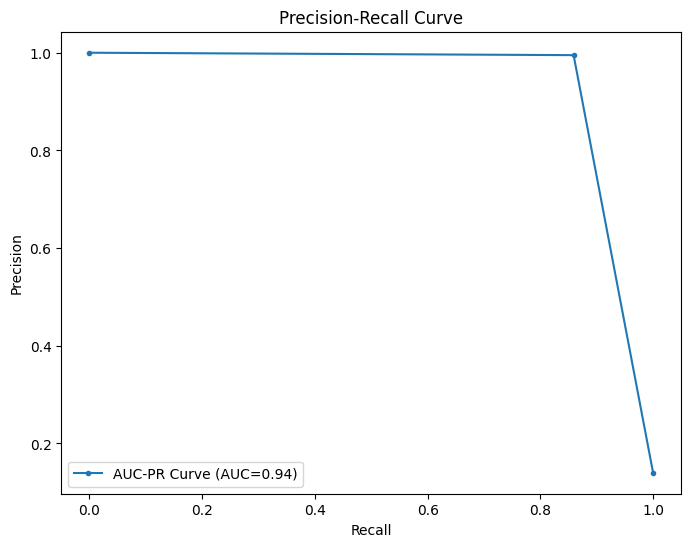

In [24]:
results_table = PrettyTable()
results_table.field_names = ["Model", "AUC-PR Score"]


for item in run_model_mapping:
    run_id = item["run_id"]
    model_name = item["model_name"]

    auc_pr = load_and_evaluate_model(run_id, model_name)
    
    results_table.add_row([model_name, f"{auc_pr:.4f}"])

In [25]:
results_table

Model,AUC-PR Score
RandomForest,0.9008
DecisionTree,0.8312
LogisticRegression,0.9226
SVC,0.9173
MultinomialNB,0.9369


## Model Performance Analysis

Based on the results table, we can see the performance of five different machine learning models for SMS spam detection:

| Model | AUC-PR Score |
|-------|--------------|
| MultinomialNB | 0.9369 |
| LogisticRegression | 0.9226 |
| SVC | 0.9173 |
| RandomForest | 0.9008 |
| DecisionTree | 0.8312 |

The Area Under the Precision-Recall Curve (AUC-PR) is particularly useful for imbalanced classification problems like spam detection. Higher values indicate better model performance.

Key observations:
- **MultinomialNB** performs best with an AUC-PR of 0.9369, which is expected since Naive Bayes models work well with text classification tasks
- **LogisticRegression** is a close second with 0.9226
- **SVC** (Support Vector Classifier) shows strong performance at 0.9173
- **RandomForest** performs well at 0.9008
- **DecisionTree** has the lowest score at 0.8312, showing that simpler tree models may not capture the complexity of text data as effectively

The high performance across most models indicates that the features extracted from the text data are highly informative for distinguishing between spam and non-spam messages.

However, we would select `MultinomialNB` as the best model.